In [1]:
import pandas as pd
import pqr


# Load and preprocess the data

In [2]:
prices = pd.read_csv("factors/russia/close_price.csv", parse_dates=True, index_col=0)["2003":].iloc[:-1]
pe = pd.read_csv("factors/russia/pe.csv", parse_dates=True, index_col=0)["2003":].iloc[:-1]
volume = pd.read_csv("factors/russia/trading_volume.csv", parse_dates=True, index_col=0)["2003":].iloc[:-1]
volume = prices * volume  # convert volume from lots to money

prices, pe, volume = pqr.utils.replace_with_nan(prices, pe, volume, to_replace=0)
prices, pe, volume = pqr.utils.align(prices, pe, volume)

# Define stock universe, prepare benchmark and make dashboard

In [3]:
universe = volume >= 1_000_000
returns_calculator = pqr.utils.partial(
    pqr.calculate_returns, 
    universe_returns=pqr.prices_to_returns(prices),
)

benchmark = pqr.Benchmark.from_universe(
    universe=universe,
    allocator=pqr.equal_weights,
    calculator=returns_calculator,
)

In [4]:
table = pqr.metrics.Table()
table.add_metric(
    pqr.utils.partial(
        pqr.metrics.mean_return,
        statistics=True,
        annualizer=1,
    ),
    multiplier=100,
    precision=2,
    name="Monthly Mean Return, %",
)
table.add_metric(
    pqr.utils.partial(
        pqr.metrics.volatility,
        annualizer=1,
    ),
    multiplier=100,
    precision=2,
    name="Monthly Volatility, %",
)
table.add_metric(
    pqr.metrics.max_drawdown,
    multiplier=100,
    name="Maximum Drawdown, %",
)
table.add_metric(
    pqr.utils.partial(
        pqr.metrics.mean_excess_return,
        benchmark=benchmark,
        statistics=True,
        annualizer=1,
    ),
    multiplier=100,
    precision=2,
    name="Monthly Mean Excess Return, %",
)
table.add_metric(
    pqr.utils.partial(
        pqr.metrics.alpha,
        benchmark=benchmark,
        statistics=True,
        annualizer=1,
    ),
    multiplier=100,
    precision=2,
    name="Monthly Alpha, %",
    
)
table.add_metric(
    pqr.utils.partial(
        pqr.metrics.beta,
        benchmark=benchmark,
        statistics=True,
    ),
    precision=2,
    name="Monthly Beta, %",
)

fig = pqr.metrics.Figure(
    pqr.metrics.compounded_returns,
    name="Compounded Returns",
    benchmark=benchmark,
    kwargs={
        "figsize": (10, 6),
    }
)

summary = pqr.metrics.Dashboard([table, fig])

# Build a factor model and analyse it

In [5]:
static_transform = pqr.utils.compose(
    pqr.utils.partial(pqr.factors.filter, universe=universe),
    pqr.utils.partial(pqr.factors.look_back_median, period=3),
    pqr.utils.partial(pqr.factors.hold, period=3),
)

value = static_transform(pe)

,Winners,Neutral 1,Losers,WML
"Monthly Mean Return, %",1.49*** (2.98),1.41*** (2.55),1.36*** (2.70),0.13 (0.33)
"Monthly Volatility, %",7.42,8.22,7.46,5.96
"Maximum Drawdown, %",-60.56,-75.43,-64.91,-61.26
"Monthly Mean Excess Return, %",0.08 (0.36),-0.00 (-0.01),-0.05 (-0.17),-1.28 (-2.19)
"Monthly Alpha, %",0.15 (0.65),-0.06 (-0.25),0.15 (0.48),0.00 (0.00)
"Monthly Beta, %",0.95*** (29.42),1.04*** (28.17),0.86*** (19.82),0.09 (1.61)


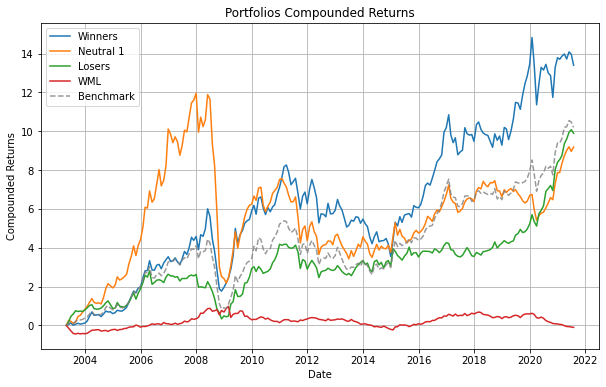

In [6]:
portfolios = pqr.factors.backtest_factor_portfolios(
    factor=value,
    strategies=pqr.factors.split_quantiles(3, "less"),
    allocator=pqr.equal_weights,
    calculator=returns_calculator,
    add_wml=True,
)

summary.display(portfolios)